Explore dEBM data to see why catchment means negative, based on the processing for GrSMBMIP.  

Last updated: 5 Jan 2023 | EHU

In [1]:
from shapely.geometry import MultiPoint
from shapely.ops import triangulate
import shapefile
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pyproj as pyproj
from scipy import interpolate
import datetime
import time

In [2]:
###------------------------
### DATA READ-IN  AND PROJECTION
###------------------------

## Read in BedMachine grid to reproject SMB
gl_bed_path ='/Volumes/GoogleDrive/My Drive/Greenland-data/BedMachine-Greenland/BedMachineGreenland-2017-09-20.nc'
fh = Dataset(gl_bed_path, mode='r')
xx = fh.variables['x'][:].copy() #x-coord (polar stereo (70, 45))
yy = fh.variables['y'][:].copy() #y-coord
ss = fh.variables['surface'][:].copy() # surface elevation
M = fh.variables['mask'][:].copy() ## land cover type mask (2 = grounded ice)
fh.close()

## Read in Mouginot catchments from shapefile
print('Reading in Mouginot catchments')
catchment_fn = '/Volumes/GoogleDrive/My Drive/Greenland-data/Greenland-catchments-Mouginot/Greenland_Basins_PS_v1.4.2.'
sf = shapefile.Reader(catchment_fn) 

Reading in Mouginot catchments


In [4]:
## read in ISMIP6 grid for geometry
print('Reading in ISMIP6 geometry')
# geom_path = '/Users/eultee@middlebury.edu/Documents/Research/data/5km_ISMIP6grid.nc'
geom_path = '/Volumes/GoogleDrive/Other computers/My iMac/Research/data/5km_ISMIP6grid.nc'
fh3 = Dataset(geom_path, mode='r')
x_lon_debm = fh3.variables['lon'][:].copy() # longitude
y_lat_debm = fh3.variables['lat'][:].copy() # latitude
fh3.close()

Reading in ISMIP6 geometry


In [5]:
## dEBM read in for preliminary view
print('Reading in example dEBM field')
# debm_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_2007.nc'
debm_path = '/Volumes/GoogleDrive/Other computers/My iMac/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_2007.nc'
fh2 = Dataset(debm_path, mode='r')
# x_debm = fh2.dimensions['x'].copy() #x-coord (polar stereo?)
# y_debm = fh2.dimensions['y'].copy() #y-coord 
smb_debm = fh2.variables['SMB'][:].copy()
fh2.close()

Reading in example dEBM field


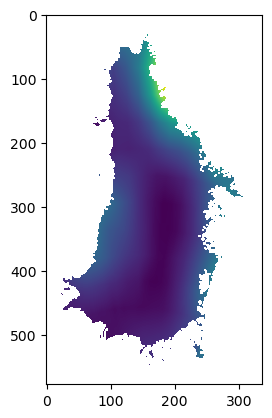

In [6]:
import matplotlib.pyplot as plt
plt.imshow(smb_debm[0])
plt.show()

In [21]:
smb_debm[0].min()

3.756580166518688

In [22]:
###------------------------
### SET UP SMB REPROJECTION
###------------------------

## Down-sample bed topo
x_3km = xx[::20] # sample at ~3 km resolution
y_3km = yy[::20]
s_3km = ss[::20,::20] ## we'll use surface elevation for monthly lapse rate
Xmat, Ymat = np.meshgrid(x_3km, y_3km) # Downsampled BedMachine coords

print('Creating reprojected grid')
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by SMB data
psn_gl = pyproj.Proj("+init=epsg:3413") # Polar Stereographic North used by BedMachine and Mankoff
xs, ys = pyproj.transform(wgs84, psn_gl, x_lon_debm, y_lat_debm)

Creating reprojected grid


/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

In [23]:
###------------------------
### CHOOSE CATCHMENTS
###------------------------
first_ctmt = 0
last_ctmt = 10 ## confirmed that 260 should be end of the catchments available by running to 300, got error after 259
catchments_to_pull = np.arange(first_ctmt, last_ctmt).tolist()

In [24]:
###------------------------
### CREATE FRAMEWORK
###------------------------

caps_and_disjoint = []

## Perform Delaunay triangulation over each catchment region
tri_ctmts = {i: [] for i in catchments_to_pull}
for i in catchments_to_pull:
    print('Triangulating catchment {}'.format(sf.record(i)['NAME']))
    c = MultiPoint(sf.shape(i).points)
    tris = triangulate(c)
    tri_ctmts[i] = tris
    if 'ICE_CAPS' in sf.record(i)['NAME']:
        caps_and_disjoint.append(i)
    elif len(sf.shape(i).parts)>1:
        caps_and_disjoint.append(i)


years = range(2007,2018) ## calibration period 2007-2017 inclusive
start_date = datetime.datetime(years[0],1,1)
end_date = datetime.datetime(years[-1],12,31)
dates = pd.date_range(start=start_date, end=end_date, freq='M')
df_record = pd.DataFrame(columns=[i for i in catchments_to_pull], index=dates)
df_elev_per_ctmt = {i: 
                    {n: 
                     {y: pd.DataFrame(columns=('elevation', 
                                                     'point_smb')) for y in years} for n in range(12)} for i in catchments_to_pull}

Triangulating catchment UMIAMMAKKU_ISBRAE
Triangulating catchment GEIKIE_UNNAMED_VESTFORD_S
Triangulating catchment RINK_ISBRAE
Triangulating catchment KANGERLUSSUUP_SERMERSUA
Triangulating catchment CW_NONAME3
Triangulating catchment SERMEQ_SILARLEQ
Triangulating catchment CW_NONAME2
Triangulating catchment LILLE_GLETSCHER
Triangulating catchment STORE_GLETSCHER
Triangulating catchment SERMEQ_AVANNARLEQ2


KeyError: 10

In [ ]:
caps_and_disjoint

## Check total SMB series for full ice sheet

In [41]:
## Read in every year, check mean, add to series
calib_years = range(2007, 2018)
min_series, max_series, mean_series = [],[],[]

for y in calib_years:
    ## dEBM read in for preliminary view
    print('Reading in dEBM field for {}'.format(y))
    # debm_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_2007.nc'
    debm_path = '/Volumes/GoogleDrive/Other computers/My iMac/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_{}.nc'.format(y)
    fh2 = Dataset(debm_path, mode='r')
    # x_debm = fh2.dimensions['x'].copy() #x-coord (polar stereo?)
    # y_debm = fh2.dimensions['y'].copy() #y-coord 
    smb_debm = fh2.variables['SMB'][:].copy()
    fh2.close()
    for m in range(0,12):
        min_series.append(smb_debm[m].min())
        max_series.append(smb_debm[m].max())
        mean_series.append(smb_debm[m].mean())

Reading in dEBM field for 2007
Reading in dEBM field for 2008
Reading in dEBM field for 2009
Reading in dEBM field for 2010
Reading in dEBM field for 2011
Reading in dEBM field for 2012
Reading in dEBM field for 2013
Reading in dEBM field for 2014
Reading in dEBM field for 2015
Reading in dEBM field for 2016
Reading in dEBM field for 2017


In [46]:
len(mean_series)

132

In [50]:
tseries = pd.date_range(start='2007-01-01', end='2017-12-31', freq='M')
tseries

DatetimeIndex(['2007-01-31', '2007-02-28', '2007-03-31', '2007-04-30',
               '2007-05-31', '2007-06-30', '2007-07-31', '2007-08-31',
               '2007-09-30', '2007-10-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', length=132, freq='M')

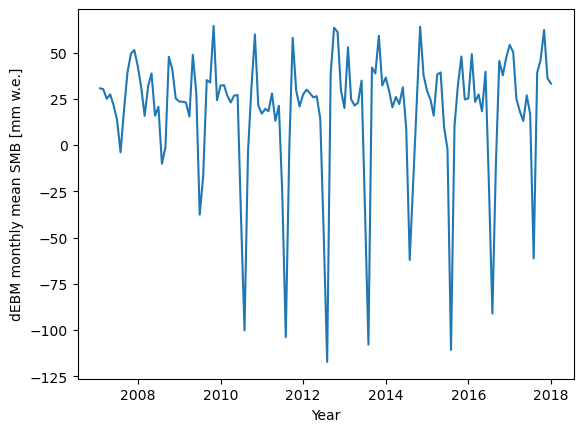

In [51]:
fig, ax = plt.subplots()
ax.plot(tseries,mean_series)
ax.set(xlabel='Year', ylabel='dEBM monthly mean SMB [mm w.e.]')
plt.show()

## Catchment summing

In [ ]:
###------------------------
### CATCHMENT-SUM FOR ALL MODELS
###------------------------

t0 = time.time()
for y in years:
    ti = time.time()
    fpath = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_{}.nc'.format(y)
    fh = Dataset(fpath, mode='r')
    smb_m = fh.variables['SMB'][:].copy()
    fh.close()
    d_subset = [d for d in dates if d.year==y]
    for i in range(len(smb_m)): # for each month
        ## interpolate SMB
        smb_ds = smb_m[i]
        regridded_smb = interpolate.griddata((xs.ravel(), ys.ravel()), smb_ds.ravel(), (Xmat, Ymat), method='nearest')
        ## Sample SMB at each Delaunay triangle and sum
        for j in catchments_to_pull:
            if j in caps_and_disjoint:
#                 print('Identified catchment {} in ice caps and disjoint catchments. Skipping.'.format(j))
#                 df_record.drop(columns=j, inplace=True)
                pass
            else:
                catchment_sum = 0
                area_sum = 0
                triangles = tri_ctmts[j]
                for tri in triangles:
                    rep_x, rep_y = tri.representative_point().x, tri.representative_point().y
                    area_m2 = tri.area
                    smb_x = (np.abs(x_3km - rep_x)).argmin()
                    smb_y = (np.abs(y_3km - rep_y)).argmin()
                    nearest_smb = regridded_smb[smb_y, smb_x]
                    if nearest_smb < -9990: ## catch fill values or unrealistic extreme values
                        next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
                        next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
                        next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
                        ### TODO: add an option for a fill value, if next nearest is also bad?
                        local_val = next_nearest_smb*area_m2
    #                 elif nearest_smb > 6000: ## HIRHAM and SNOWMODEL have positive fill val
    #                     next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
    #                     next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
    #                     next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
    #                     ### TODO: add an option for a fill value, if next nearest is also bad?
    #                     local_val = next_nearest_smb*area_m2
                    else:
                        local_val = nearest_smb*area_m2
                    catchment_sum += local_val
                    area_sum += area_m2
                df_record[j][d_subset[i]] = catchment_sum/area_sum
    tf = time.time()
    print('Finished processing year {} in time {}s'.format(y, tf-ti))
t1 = time.time()
print('Finished processing full period in time {}'.format(t1-t0))

## Write to CSV
csv_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-processed/{}-catchments_{}to{}_mean-tseries.csv'.format(datetime.date.today().strftime('%Y%m%d'), first_ctmt, last_ctmt-1)
df_record.to_csv(csv_path)
    

## Monthly SMB lapse rates per catchment
Compute lapse rates, in the form of piecewise linear functions that may change by month.  `segments_fit` is copied from `stochSMB.py` in the main stoch-SMB repository.  It optimises for both BIC and AIC in locating inflection points.

In [ ]:
import numpy as np
from scipy import optimize

def segments_fit(X, Y, maxcount):
    xmin = X.min()
    xmax = X.max()
    
    n = len(X)
    
    AIC_ = float('inf')
    BIC_ = float('inf')
    r_   = None
    
    for count in range(1, maxcount+1):
        
        seg = np.full(count - 1, (xmax - xmin) / count)

        px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.1].mean() for x in px_init])

        def func(p):
            seg = p[:count - 1]
            py = p[count - 1:]
            px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
            return px, py

        def err(p): # This is RSS / n
            px, py = func(p)
            Y2 = np.interp(X, px, py)
            return np.mean((Y - Y2)**2)

        r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    
        # Compute AIC/ BIC. 
        AIC = n * np.log10(err(r.x)) + 4 * count
        BIC = n * np.log10(err(r.x)) + 2 * count * np.log(n)
        
        if((BIC < BIC_) & (AIC < AIC_)): # Continue adding complexity.
            r_ = r
            AIC_ = AIC
            BIC_ = BIC
        else: # Stop.
            count = count - 1
            break
        
    return func(r_.x) ## Return the last (n-1)

In [ ]:
## Do another massive process per catchment...
 
t0 = time.time()
for y in years:
    ti = time.time()
    fpath = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_{}.nc'.format(y)
    fh = Dataset(fpath, mode='r')
    smb_m = fh.variables['SMB'][:].copy()
    fh.close()
    d_subset = [d for d in dates if d.year==y]
    for i in range(len(smb_m)): # for each month
        ## interpolate SMB
        smb_ds = smb_m[i]
        regridded_smb = interpolate.griddata((xs.ravel(), ys.ravel()), smb_ds.ravel(), (Xmat, Ymat), method='nearest')
        ## Sample SMB at each Delaunay triangle and write to dataframe
        for j in catchments_to_pull:
            if j in caps_and_disjoint:
#                 print('Identified catchment {} in ice caps and disjoint catchments. Skipping.'.format(j))
#                 df_record.drop(columns=j, inplace=True)
                pass
            else:
                triangles = tri_ctmts[j]
                elevations = []
                smb_point_vals = []
                for tri in triangles:
                    rep_x, rep_y = tri.representative_point().x, tri.representative_point().y
                    smb_x = (np.abs(x_3km - rep_x)).argmin()
                    smb_y = (np.abs(y_3km - rep_y)).argmin()
                    elevations.append(s_3km[smb_y, smb_x])
                    nearest_smb = regridded_smb[smb_y, smb_x]
                    if nearest_smb < -9990: ## catch fill values or unrealistic extreme values
                        next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
                        next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
                        next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
                        ### TODO: add an option for a fill value, if next nearest is also bad?
                        smb_point_vals.append(next_nearest_smb)
                    else:
                        smb_point_vals.append(nearest_smb)
                df_elev_per_ctmt[j][i][y] = df_elev_per_ctmt[j][i][y].assign(elevation=elevations,
                                            point_smb=smb_point_vals)
    tf = time.time()
    print('Finished processing year {} in time {}s'.format(y, tf-ti))
t1 = time.time()
print('Finished processing full period in time {}'.format(t1-t0))


Now stack all the same-month values from the full period and use these to regress the lapse rate.

In [ ]:
## Test for just one catchment
test_catchment = 1
df_c = df_elev_per_ctmt[test_catchment]
monthly_mbg = {i: [] for i in range(12)}

for i in range(12):
    d_to_join = [df_c[i][y] for y in years]
    df = pd.concat(d_to_join) ## take just this month's values
    pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
    anomalies = pt_smbs - np.mean(pt_smbs)
    px, py = segments_fit(np.asarray(df.sort_values(by='elevation')['elevation']),
                          anomalies,
                          maxcount=2)
    monthly_mbg[i] = (px,py)

In [ ]:
## Set up write-out dataframe and write for each catchment
df_mbg_output = pd.DataFrame(columns=['Catchment {}'.format(i) for i in catchments_to_pull], index=np.arange(0,12))

for c in catchments_to_pull:
    if c in caps_and_disjoint:
#                 print('Identified catchment {} in ice caps and disjoint catchments. Skipping.'.format(j))
#                 df_record.drop(columns=j, inplace=True)
        pass
    else:
        try:
            df_c = df_elev_per_ctmt[c]
            monthly_mbg = {i: [] for i in range(12)}

            for i in range(12):
                d_to_join = [df_c[i][y] for y in years]
                df = pd.concat(d_to_join) ## take just this month's values
                pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
                anomalies = pt_smbs - np.mean(pt_smbs)
                px, py = segments_fit(np.asarray(df.sort_values(by='elevation')['elevation']),
                                      anomalies,
                                      maxcount=2)
                monthly_mbg[i] = (px,py)
            df_mbg_output['Catchment {}'.format(c)] = pd.Series(monthly_mbg)
        except AttributeError:
            print('Error in catchment {}'.format(c))
            df_mbg_output['Catchment {}'.format(c)] = pd.Series(np.nan, index=range(12))

    

In [ ]:
# import matplotlib.pyplot as plt
# ## figure out error in catchment 193, preventing write-out
# fig, axs = plt.subplots(3, 4, sharex=True, sharey=True)
# for i in range(12):
#     ax = axs.ravel()[i]
#     d_to_join = [df_elev_per_ctmt[193][i][y] for y in years]
#     df_test = pd.concat(d_to_join)
#     pt_smbs = np.asarray(df_test.sort_values(by='elevation')['point_smb'])
#     anomalies = pt_smbs - np.mean(pt_smbs)
#     ax.scatter(df_test.sort_values(by='elevation')['elevation'], anomalies, color=c(i%12), label=dates[i].strftime('%m/%Y'))
#     ax.text(1000,-1100,'Month {}'.format(i+1))
# plt.show()

# df_test.sort_values(by='elevation')['elevation']
anomalies

In [ ]:
## Write to CSV
csv_lr_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-processed/{}-catchments_{}to{}-elev_SMB_lapserate.csv'.format(datetime.date.today().strftime('%Y%m%d'), first_ctmt, last_ctmt-1)
df_mbg_output.to_csv(csv_lr_path)

In [ ]:
df_mbg_output